# Lab 2: Exploring Image Data
## by Michael Doherty, Leilani Guzman, and Carson Pittman

## 1. Business Understanding
Link to the dataset: https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set

## 2. Data Preparation

In [130]:
import numpy as np
import PIL
import PIL.Image
import glob
import matplotlib.pyplot as plt

#load in images and labels as numpy arrays
images_and_labels = []
# labels = []
for filename in glob.glob('data/vehicles/*.png'):
    im = PIL.Image.open(filename).convert('L') # convert to grayscale
    im = np.array(im).ravel()
    images_and_labels.append(tuple((im, 'vehicle')))


for filename in glob.glob('data/non-vehicles/*.png'):
    im = PIL.Image.open(filename).convert('L') # convert to grayscale
    im = np.array(im).ravel()
    images_and_labels.append(tuple((im, 'non_vehicle')))
 

print(images_and_labels[0][0].shape[0])      # linearized 64x64 image -> 4096
print('There are', len(images_and_labels), 'images/rows')

(4096,)
There are 17760 images/rows


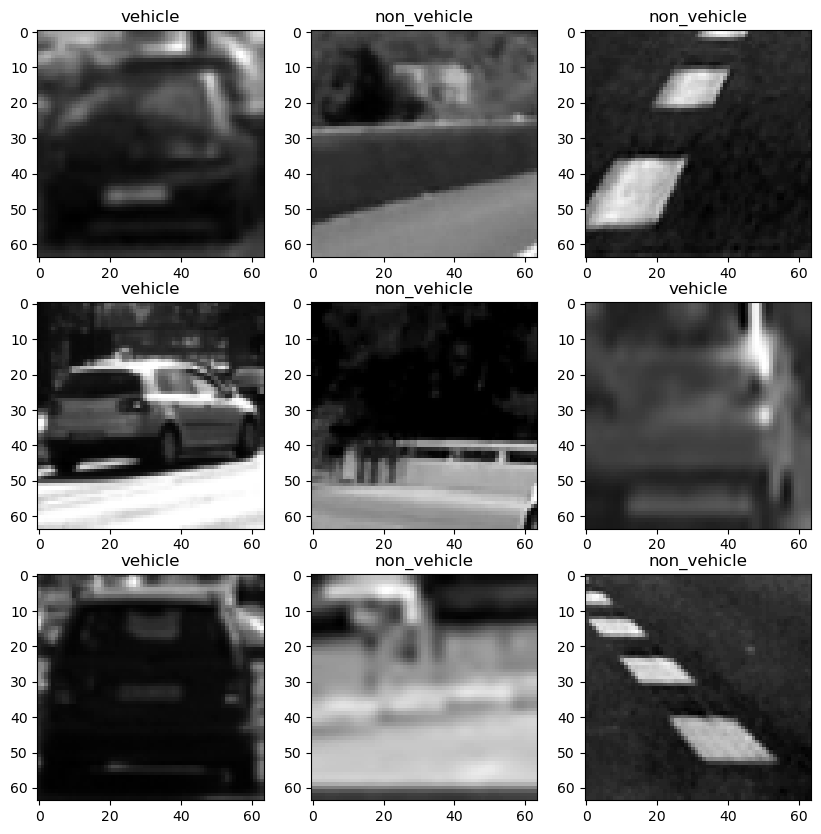

In [133]:
plt.figure(figsize=(10,10))
#plot some images
for i in range(9):
    plt.subplot(3,3, i+1)
    index = np.random.randint(0, len(images_and_labels))
    plt.imshow(images_and_labels[index][0].reshape(64,64), cmap='gray')
    plt.title(images_and_labels[index][1])

## 3. Data Reduction

In [ ]:
from sklearn.decomposition import PCA

n_components = 300

pca = PCA(n_components=n_components)
# pca.fit(images_and_labels)    # this section still needs work

# altered_images = pca.components_.reshape((n_components, 64, 64))

## 4. Feature Extraction Using DAISY Key Point Matching